In [ ]:
import pandas as pd
import os
dirname = globals()['_dh'][0]
train = pd.read_csv(os.path.join(dirname, 'train_bert.csv'), encoding='unicode_escape')
test = pd.read_csv(os.path.join(dirname, 'test_bert.csv'), encoding='unicode_escape')

In [ ]:
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertModel, BertConfig, BertPreTrainedModel, Trainer, TrainingArguments
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

le = LabelEncoder()
train['sent_encoded'] = le.fit_transform(train['sentiment'])
test['sent_encoded'] = le.transform(test['sentiment'])
num_labels = len(le.classes_)

tfidf = TfidfVectorizer(max_features=5000)
train_tfidf = tfidf.fit_transform(train['text_preprocessed']).toarray()
test_tfidf = tfidf.transform(test['text_preprocessed']).toarray()

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, texts, tfidf_features, labels, tokenizer, max_length=128):
        self.encodings = tokenizer(texts.tolist(), truncation=True, padding=True, max_length=max_length)
        self.tfidf_features = torch.tensor(tfidf_features, dtype=torch.float32)
        self.labels = labels.reset_index(drop=True)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['tfidf_features'] = self.tfidf_features[idx]
        item['labels'] = torch.tensor(int(self.labels[idx]))
        return item

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_dataset = CustomDataset(train['text_preprocessed'], train_tfidf, train['sent_encoded'], tokenizer)
test_dataset  = CustomDataset(test['text_preprocessed'], test_tfidf, test['sent_encoded'], tokenizer)

class CustomBertModel(BertPreTrainedModel):
    def __init__(self, config, tfidf_dim=5000):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.bert = BertModel(config)

        bert_hidden_size = config.hidden_size
        input_dim = bert_hidden_size + tfidf_dim  # Add TF-IDF dimension
        classifier_hidden_size = bert_hidden_size * 3 // 2

        self.classifier = nn.Sequential(
            nn.Linear(input_dim, classifier_hidden_size),
            nn.LeakyReLU(),
            nn.LayerNorm(classifier_hidden_size),
            nn.Dropout(0.2),
            nn.Linear(classifier_hidden_size, classifier_hidden_size),
            nn.LeakyReLU(),
            nn.LayerNorm(classifier_hidden_size),
            nn.Dropout(0.2),
            nn.Linear(classifier_hidden_size, classifier_hidden_size),
            nn.LeakyReLU(),
            nn.LayerNorm(classifier_hidden_size),
            nn.Linear(classifier_hidden_size, config.num_labels)
        )
        self.loss_fn = nn.CrossEntropyLoss()
        self.init_weights()

    def forward(self, input_ids, attention_mask, token_type_ids=None, tfidf_features=None, labels=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        pooled_output = outputs[1] if outputs[1] is not None else outputs.last_hidden_state[:, 0, :]

        # Concatenate BERT output with TF-IDF features
        combined = torch.cat([pooled_output, tfidf_features], dim=1)

        logits = self.classifier(combined)
        loss = self.loss_fn(logits, labels) if labels is not None else None

        return {"loss": loss, "logits": logits}

config = BertConfig.from_pretrained('bert-base-uncased', num_labels=num_labels)
model = CustomBertModel.from_pretrained('bert-base-uncased', config=config)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    accuracy = accuracy_score(labels, preds)
    f1_macro = f1_score(labels, preds, average="macro")
    return {"accuracy": accuracy, "f1_macro": f1_macro}

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir='./logs',
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

trainer.train()

eval_result = trainer.evaluate()
print(eval_result)

Some weights of CustomBertModel were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.0.bias', 'classifier.0.weight', 'classifier.10.bias', 'classifier.10.weight', 'classifier.11.bias', 'classifier.11.weight', 'classifier.2.bias', 'classifier.2.weight', 'classifier.4.bias', 'classifier.4.weight', 'classifier.6.bias', 'classifier.6.weight', 'classifier.8.bias', 'classifier.8.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.616500,0.611380,0.770798,0.773599
2,0.342800,0.566168,0.794284,0.797652
3,0.404400,0.716021,0.798246,0.801348


{'eval_loss': 0.7160205841064453, 'eval_accuracy': 0.7982456140350878, 'eval_f1_macro': 0.8013478257795453, 'eval_runtime': 13.2728, 'eval_samples_per_second': 266.258, 'eval_steps_per_second': 33.301, 'epoch': 3.0}


In [ ]:
import torch
import torch.nn as nn
from transformers import RobertaTokenizer, RobertaModel, RobertaConfig, RobertaPreTrainedModel, Trainer, TrainingArguments
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

le = LabelEncoder()
train['sent_encoded'] = le.fit_transform(train['sentiment'])
test['sent_encoded'] = le.transform(test['sentiment'])
num_labels = len(le.classes_)

tfidf = TfidfVectorizer(max_features=5000)
train_tfidf = tfidf.fit_transform(train['text_preprocessed']).toarray()
test_tfidf = tfidf.transform(test['text_preprocessed']).toarray()

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, texts, tfidf_features, labels, tokenizer, max_length=128):
        self.encodings = tokenizer(texts.tolist(), truncation=True, padding=True, max_length=max_length)
        self.tfidf_features = torch.tensor(tfidf_features, dtype=torch.float32)
        self.labels = labels.reset_index(drop=True)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['tfidf_features'] = self.tfidf_features[idx]
        item['labels'] = torch.tensor(int(self.labels[idx]))
        return item

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
train_dataset = CustomDataset(train['text_preprocessed'], train_tfidf, train['sent_encoded'], tokenizer)
test_dataset  = CustomDataset(test['text_preprocessed'], test_tfidf, test['sent_encoded'], tokenizer)

class CustomRobertaModel(RobertaPreTrainedModel):
    def __init__(self, config, tfidf_dim=5000):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.roberta = RobertaModel(config)

        roberta_hidden_size = config.hidden_size
        input_dim = roberta_hidden_size + tfidf_dim  # Add TF-IDF dimension
        classifier_hidden_size = roberta_hidden_size * 3 // 2

        self.classifier = nn.Sequential(
            nn.Linear(input_dim, classifier_hidden_size),
            nn.LeakyReLU(),
            nn.LayerNorm(classifier_hidden_size),
            nn.Dropout(0.2),
            nn.Linear(classifier_hidden_size, classifier_hidden_size),
            nn.LeakyReLU(),
            nn.LayerNorm(classifier_hidden_size),
            nn.Dropout(0.2),
            nn.Linear(classifier_hidden_size, classifier_hidden_size),
            nn.LeakyReLU(),
            nn.LayerNorm(classifier_hidden_size),
            nn.Linear(classifier_hidden_size, config.num_labels)
        )
        self.loss_fn = nn.CrossEntropyLoss()
        self.init_weights()

    def forward(self, input_ids, attention_mask, token_type_ids=None, tfidf_features=None, labels=None):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        pooled_output = outputs[1] if outputs[1] is not None else outputs.last_hidden_state[:, 0, :]

        # Concatenate BERT output with TF-IDF features
        combined = torch.cat([pooled_output, tfidf_features], dim=1)

        logits = self.classifier(combined)
        loss = self.loss_fn(logits, labels) if labels is not None else None

        return {"loss": loss, "logits": logits}

config = RobertaConfig.from_pretrained('roberta-base', num_labels=num_labels)
model = CustomRobertaModel.from_pretrained('roberta-base', config=config)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    accuracy = accuracy_score(labels, preds)
    f1_macro = f1_score(labels, preds, average="macro")
    return {"accuracy": accuracy, "f1_macro": f1_macro}

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir='./logs',
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

trainer.train()

eval_result = trainer.evaluate()
print(eval_result)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of CustomRobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.0.bias', 'classifier.0.weight', 'classifier.10.bias', 'classifier.10.weight', 'classifier.11.bias', 'classifier.11.weight', 'classifier.2.bias', 'classifier.2.weight', 'classifier.4.bias', 'classifier.4.weight', 'classifier.6.bias', 'classifier.6.weight', 'classifier.8.bias', 'classifier.8.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: anthony-tamzil (anthony-tamzil-nus) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.677900,0.606120,0.773062,0.776347
2,0.381400,0.631982,0.785795,0.789403
3,0.345900,0.654878,0.788342,0.791885


{'eval_loss': 0.6548782587051392, 'eval_accuracy': 0.7883418222976797, 'eval_f1_macro': 0.7918854297834365, 'eval_runtime': 15.1905, 'eval_samples_per_second': 232.645, 'eval_steps_per_second': 29.097, 'epoch': 3.0}


BERT w scheduler and tfidf

In [ ]:
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertModel, BertConfig, BertPreTrainedModel, Trainer, TrainingArguments
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

le = LabelEncoder()
train['sent_encoded'] = le.fit_transform(train['sentiment'])
test['sent_encoded'] = le.transform(test['sentiment'])
num_labels = len(le.classes_)

tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
train_tfidf = tfidf.fit_transform(train['text_preprocessed']).toarray()
test_tfidf = tfidf.transform(test['text_preprocessed']).toarray()

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, texts, tfidf_features, labels, tokenizer, max_length=128):
        self.encodings = tokenizer(texts.tolist(), truncation=True, padding=True, max_length=max_length)
        self.tfidf_features = torch.tensor(tfidf_features, dtype=torch.float32)
        self.labels = labels.reset_index(drop=True)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['tfidf_features'] = self.tfidf_features[idx]
        item['labels'] = torch.tensor(int(self.labels[idx]))
        return item

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_dataset = CustomDataset(train['text_preprocessed'], train_tfidf, train['sent_encoded'], tokenizer)
test_dataset  = CustomDataset(test['text_preprocessed'], test_tfidf, test['sent_encoded'], tokenizer)

class CustomBertModel(BertPreTrainedModel):
    def __init__(self, config, tfidf_dim=10000): # tfidf = 10000
        super().__init__(config)
        self.num_labels = config.num_labels
        self.bert = BertModel(config)

        bert_hidden_size = config.hidden_size
        input_dim = bert_hidden_size + tfidf_dim  # Add TF-IDF dimension
        classifier_hidden_size = bert_hidden_size * 3 // 2

        self.classifier = nn.Sequential(
            nn.Linear(input_dim, classifier_hidden_size),
            nn.LeakyReLU(),
            nn.LayerNorm(classifier_hidden_size),
            nn.Dropout(0.2),
            nn.Linear(classifier_hidden_size, classifier_hidden_size),
            nn.LeakyReLU(),
            nn.LayerNorm(classifier_hidden_size),
            nn.Dropout(0.2),
            nn.Linear(classifier_hidden_size, classifier_hidden_size),
            nn.LeakyReLU(),
            nn.LayerNorm(classifier_hidden_size),
            nn.Linear(classifier_hidden_size, config.num_labels)
        )
        self.loss_fn = nn.CrossEntropyLoss()
        self.init_weights()

    def forward(self, input_ids, attention_mask, token_type_ids=None, tfidf_features=None, labels=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        pooled_output = outputs[1] if outputs[1] is not None else outputs.last_hidden_state[:, 0, :]

        # Concatenate BERT output with TF-IDF features
        combined = torch.cat([pooled_output, tfidf_features], dim=1)

        logits = self.classifier(combined)
        loss = self.loss_fn(logits, labels) if labels is not None else None

        return {"loss": loss, "logits": logits}

config = BertConfig.from_pretrained('bert-base-uncased', num_labels=num_labels)
model = CustomBertModel.from_pretrained('bert-base-uncased', config=config)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    accuracy = accuracy_score(labels, preds)
    f1_macro = f1_score(labels, preds, average="macro")
    return {"accuracy": accuracy, "f1_macro": f1_macro}

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_ratio=0.1,
    weight_decay=0.05,
    learning_rate=7e-6,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir='./logs',
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    optim="adamw_torch",
    lr_scheduler_type="linear"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

trainer.train()

eval_result = trainer.evaluate()
print(eval_result)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of CustomBertModel were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.0.bias', 'classifier.0.weight', 'classifier.10.bias', 'classifier.10.weight', 'classifier.11.bias', 'classifier.11.weight', 'classifier.2.bias', 'classifier.2.weight', 'classifier.4.bias', 'classifier.4.weight', 'classifier.6.bias', 'classifier.6.weight', 'classifier.8.bias', 'classifier.8.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: anthony-tamzil (anthony-tamzil-nus) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.532500,0.557976,0.795416,0.798990
2,0.272900,0.631170,0.799377,0.802794
3,0.453000,0.667378,0.794284,0.797583


{'eval_loss': 0.6311702728271484, 'eval_accuracy': 0.7993774759479344, 'eval_f1_macro': 0.8027937034872213, 'eval_runtime': 13.3474, 'eval_samples_per_second': 264.77, 'eval_steps_per_second': 33.115, 'epoch': 3.0}


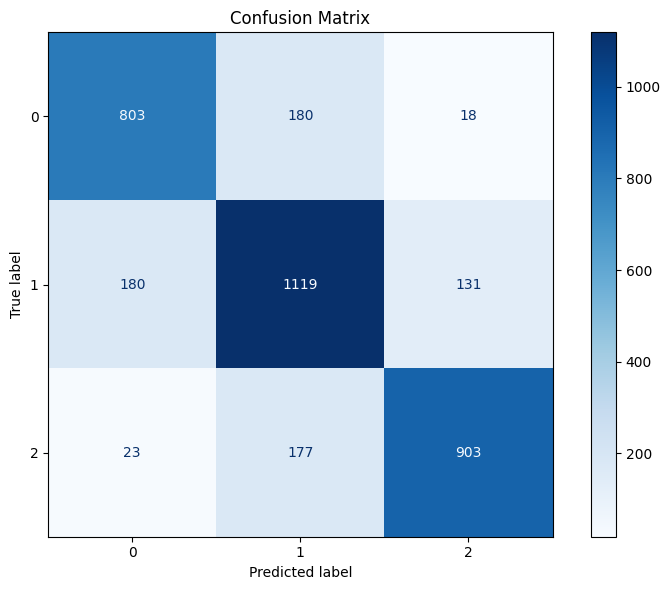

Predictions saved to test_predictions.csv


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Get predictions on test set
predictions = trainer.predict(test_dataset)
preds = predictions.predictions.argmax(-1)
labels = predictions.label_ids

# Compute confusion matrix
cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap="Blues")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

output_df = pd.DataFrame({
    "text": test["text_preprocessed"],
    "true_label": le.inverse_transform(labels),
    "predicted_label": le.inverse_transform(preds)
})

output_df.to_csv("BERTwTFIDF.csv", index=False)
print("Predictions saved to test_predictions.csv")

RoBERTa w tfidf and scheduler

In [ ]:
import torch
import torch.nn as nn
from transformers import RobertaTokenizer, RobertaModel, RobertaConfig, RobertaPreTrainedModel, Trainer, TrainingArguments
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

le = LabelEncoder()
train['sent_encoded'] = le.fit_transform(train['sentiment'])
test['sent_encoded'] = le.transform(test['sentiment'])
num_labels = len(le.classes_)

tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
train_tfidf = tfidf.fit_transform(train['text_preprocessed']).toarray()
test_tfidf = tfidf.transform(test['text_preprocessed']).toarray()

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, texts, tfidf_features, labels, tokenizer, max_length=128):
        self.encodings = tokenizer(texts.tolist(), truncation=True, padding=True, max_length=max_length)
        self.tfidf_features = torch.tensor(tfidf_features, dtype=torch.float32)
        self.labels = labels.reset_index(drop=True)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['tfidf_features'] = self.tfidf_features[idx]
        item['labels'] = torch.tensor(int(self.labels[idx]))
        return item

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
train_dataset = CustomDataset(train['text_preprocessed'], train_tfidf, train['sent_encoded'], tokenizer)
test_dataset  = CustomDataset(test['text_preprocessed'], test_tfidf, test['sent_encoded'], tokenizer)

class CustomRobertaModel(RobertaPreTrainedModel):
    def __init__(self, config, tfidf_dim=10000):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.roberta = RobertaModel(config)

        roberta_hidden_size = config.hidden_size
        input_dim = roberta_hidden_size + tfidf_dim  # Add TF-IDF dimension
        classifier_hidden_size = roberta_hidden_size * 3 // 2

        self.classifier = nn.Sequential(
            nn.Linear(input_dim, classifier_hidden_size),
            nn.LeakyReLU(),
            nn.LayerNorm(classifier_hidden_size),
            nn.Dropout(0.2),
            nn.Linear(classifier_hidden_size, classifier_hidden_size),
            nn.LeakyReLU(),
            nn.LayerNorm(classifier_hidden_size),
            nn.Dropout(0.2),
            nn.Linear(classifier_hidden_size, classifier_hidden_size),
            nn.LeakyReLU(),
            nn.LayerNorm(classifier_hidden_size),
            nn.Linear(classifier_hidden_size, config.num_labels)
        )
        self.loss_fn = nn.CrossEntropyLoss()
        self.init_weights()

    def forward(self, input_ids, attention_mask, token_type_ids=None, tfidf_features=None, labels=None):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        pooled_output = outputs[1] if outputs[1] is not None else outputs.last_hidden_state[:, 0, :]

        # Concatenate BERT output with TF-IDF features
        combined = torch.cat([pooled_output, tfidf_features], dim=1)

        logits = self.classifier(combined)
        loss = self.loss_fn(logits, labels) if labels is not None else None

        return {"loss": loss, "logits": logits}

config = RobertaConfig.from_pretrained('roberta-base', num_labels=num_labels)
model = CustomRobertaModel.from_pretrained('roberta-base', config=config)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    accuracy = accuracy_score(labels, preds)
    f1_macro = f1_score(labels, preds, average="macro")
    return {"accuracy": accuracy, "f1_macro": f1_macro}

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_ratio=0.1,
    weight_decay=0.05,
    learning_rate=7e-6,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir='./logs',
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    optim="adamw_torch",
    lr_scheduler_type="linear"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

trainer.train()

eval_result = trainer.evaluate()
print(eval_result)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of CustomRobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.0.bias', 'classifier.0.weight', 'classifier.10.bias', 'classifier.10.weight', 'classifier.11.bias', 'classifier.11.weight', 'classifier.2.bias', 'classifier.2.weight', 'classifier.4.bias', 'classifier.4.weight', 'classifier.6.bias', 'classifier.6.weight', 'classifier.8.bias', 'classifier.8.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.535400,0.538957,0.808432,0.811185
2,0.307600,0.561083,0.807018,0.810220
3,0.391000,0.602846,0.804471,0.807795


{'eval_loss': 0.5389567613601685, 'eval_accuracy': 0.8084323712507074, 'eval_f1_macro': 0.8111847203961041, 'eval_runtime': 15.5534, 'eval_samples_per_second': 227.218, 'eval_steps_per_second': 28.418, 'epoch': 3.0}


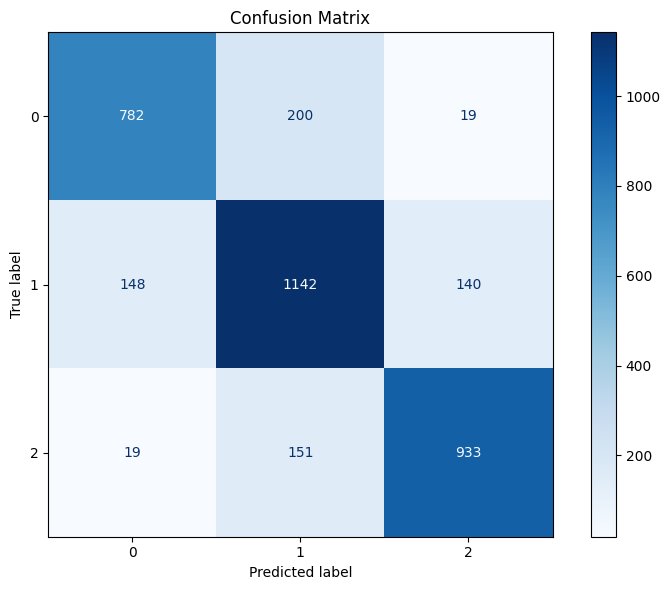

Predictions saved to test_predictions.csv


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Get predictions on test set
predictions = trainer.predict(test_dataset)
preds = predictions.predictions.argmax(-1)
labels = predictions.label_ids

# Compute confusion matrix
cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap="Blues")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

output_df = pd.DataFrame({
    "text": test["text_preprocessed"],
    "true_label": le.inverse_transform(labels),
    "predicted_label": le.inverse_transform(preds)
})

output_df.to_csv("RoBERTawTFIDF.csv", index=False)
print("Predictions saved to test_predictions.csv")